In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import keras_cv
from keras import ops
from keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
keras.utils.set_random_seed(42)

2025-10-27 05:57:13.562136: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

Total training examples: 50000
Total test examples: 10000


In [3]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 1
IMAGE_SIZE = 72

In [4]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255), augmentations_per_image=3, magnitude=0.8
)

I0000 00:00:1761541533.811578   14607 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9048 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [5]:
train_ds_rand = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (rand_augment(tf.cast(x, tf.uint8)), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

In [6]:
simple_aug = keras.Sequential(
    [
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ]
)

# Now, map the augmentation pipeline to our training dataset
train_ds_simple = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

2025-10-27 06:06:09.393141: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node rand_augment_1/map/while/body/_1/rand_augment_1/map/while/cond_1/else/_72/rand_augment_1/map/while/cond_1/random_choice_1/switch_case/indexed_case/branch9/_155/rand_augment_1/map/while/cond_1/random_choice_1/switch_case/indexed_case/random_translation_1_1/stateful_uniform_1/Cast_1/_132}}]]
	 [[rand_augment_1/map/while/body/_1/rand_augment_1/map/while/cond_2/pivot_f/_83/_178]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-10-27 06:06:09.393208: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node rand_augment_1/map/while/body/_1/rand_augment_1/map/while/cond_1/else/_72/rand_augment_1/map/while/cond_1/random_choice_1/switch_case/indexed_case/branch9/_155/rand_augment_1/map/while/cond_1/random_choice_1/switch_case/indexed_case/

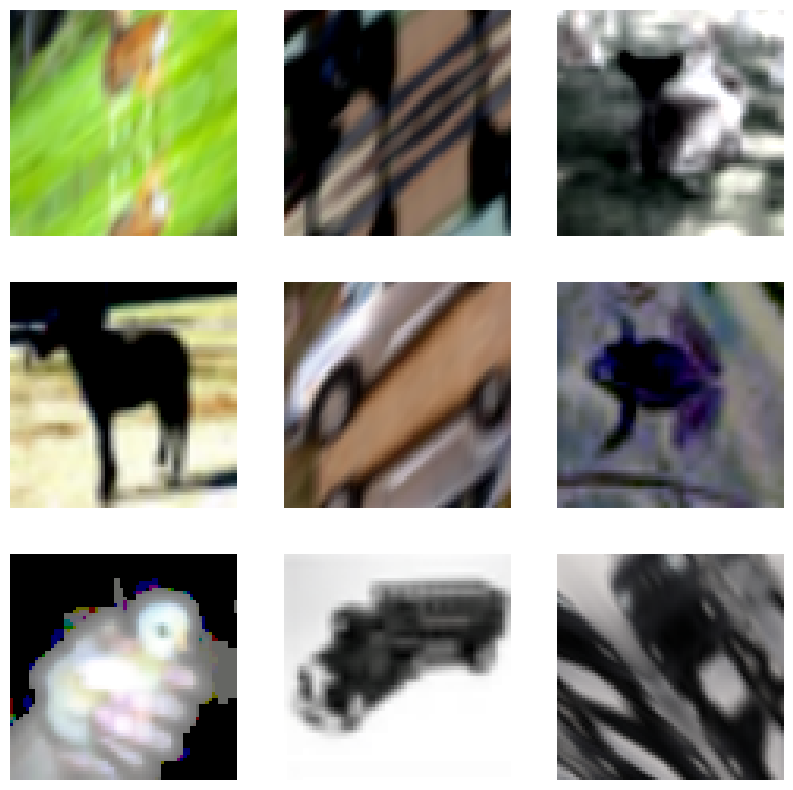

In [7]:
sample_images, _ = next(iter(train_ds_rand))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

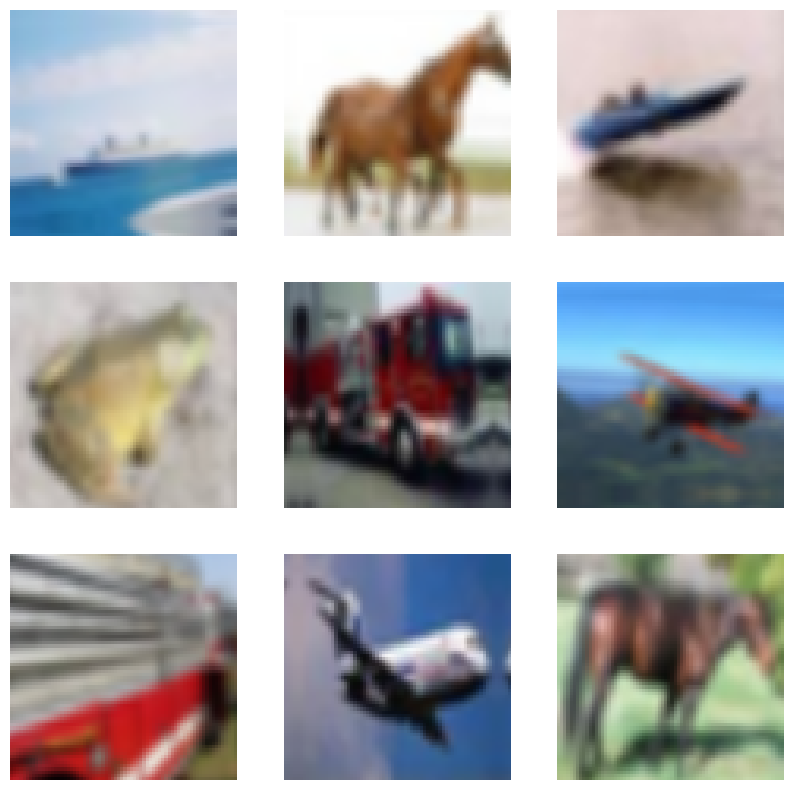

In [8]:
sample_images, _ = next(iter(train_ds_simple))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

In [9]:
def get_training_model():
    resnet50_v2 = keras.applications.ResNet50V2(
        weights=None,
        include_top=True,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        classes=10,
    )
    model = keras.Sequential(
        [
            layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
            layers.Rescaling(scale=1.0 / 127.5, offset=-1),
            resnet50_v2,
        ]
    )
    return model


get_training_model().summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 72, 72, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 10)             │    23,585,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,585,290 (89.97 MB)

 Trainable params: 23,539,850 (89.80 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [10]:
initial_model = get_training_model()
initial_model.save_weights("initial.weights.h5")

In [11]:
rand_aug_model = get_training_model()
rand_aug_model.load_weights("initial.weights.h5")
rand_aug_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
rand_aug_model.fit(train_ds_rand, validation_data=test_ds, epochs=EPOCHS)
_, test_acc = rand_aug_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

2025-10-27 06:07:35.341077: I external/local_xla/xla/service/service.cc:163] XLA service 0x7a088c002400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-27 06:07:35.341092: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-10-27 06:07:35.739016: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-27 06:07:38.018967: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300


  2/391 ━━━━━━━━━━━━━━━━━━━━ 31s 82ms/step - accuracy: 0.1094 - loss: 2.7377   

I0000 00:00:1761541669.654704   14855 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 ━━━━━━━━━━━━━━━━━━━━ 98s 184ms/step - accuracy: 0.1907 - loss: 2.2077 - val_accuracy: 0.2563 - val_loss: 2.1750
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2563 - loss: 2.1750
Test accuracy: 25.63%


In [12]:
simple_aug_model = get_training_model()
simple_aug_model.load_weights("initial.weights.h5")
simple_aug_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
simple_aug_model.fit(train_ds_simple, validation_data=test_ds, epochs=EPOCHS)
_, test_acc = simple_aug_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

391/391 ━━━━━━━━━━━━━━━━━━━━ 74s 137ms/step - accuracy: 0.4653 - loss: 1.4933 - val_accuracy: 0.4749 - val_loss: 1.5764
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4749 - loss: 1.5764
Test accuracy: 47.49%


In [13]:
# Load and prepare the CIFAR-10-C dataset
# (If it's not already downloaded, it takes ~10 minutes of time to download)
cifar_10_c = tfds.load("cifar10_corrupted/saturate_5", split="test", as_supervised=True)
cifar_10_c = cifar_10_c.batch(BATCH_SIZE).map(
    lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
    num_parallel_calls=AUTO,
)

# Evaluate `rand_aug_model`
_, test_acc = rand_aug_model.evaluate(cifar_10_c, verbose=0)
print(
    "Accuracy with RandAugment on CIFAR-10-C (saturate_5): {:.2f}%".format(
        test_acc * 100
    )
)

# Evaluate `simple_aug_model`
_, test_acc = simple_aug_model.evaluate(cifar_10_c, verbose=0)
print(
    "Accuracy with simple_aug on CIFAR-10-C (saturate_5): {:.2f}%".format(
        test_acc * 100
    )
)

Dataset cifar10_corrupted downloaded and prepared to /home/xy/tensorflow_datasets/cifar10_corrupted/saturate_5/1.0.0. Subsequent calls will reuse this data.


2025-10-27 06:29:28.583319: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


Accuracy with RandAugment on CIFAR-10-C (saturate_5): 20.47%
Accuracy with simple_aug on CIFAR-10-C (saturate_5): 34.94%
